In [35]:
# loading the language label dictionary
itol_language = {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}
# Loading the FER label dictionary
itol_FER = {0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}

There is label inconsistency, Thus one one label Dictionary will be choosen i.e. the FER label dictionary for the prediction.

The language labels will be rearranged by the following oder: (5, 3, 0, 6, 4, 2, 1)

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

# 1. Language Model

Instance of Language Model

In [4]:
import torch
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 768
hidden_dim = 128
output_dim = 7
num_layers = 1

language_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
language_model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [8]:
language_model_state_dict = torch.load("lstm_model.pth")
language_model.load_state_dict(language_model_state_dict)

<All keys matched successfully>

In [11]:
language_model

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

Preprocessing language model

In [17]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
# Preprocessing function
def generate_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings of the [CLS] token (index 0) for the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.float()

The following prediction fuction is arranged such that the prediction probabilities order are consistent with FER prediction

In [166]:
# Prediction function
def predict_text_expression(text):
  arranging_order = [5, 3, 0, 6, 4, 2, 1]
  with torch.inference_mode():
    embedded_text = generate_bert_embeddings(text).to(device)
    logits = language_model(embedded_text.unsqueeze(0))
    probs = torch.softmax(logits, dim=1).squeeze()
    probs = probs[arranging_order]
    label = probs.argmax(0)
    return itol_FER[label.item()], probs

In [168]:
# Checking the predictions from the model
text = ["She was so dirty",
        "This time I won the game, yes",
        "England lost the game this time",
        "WOW, That was totally unexpected"]
for sentence in text:
  prediction, _ = predict_text_expression(sentence)
  print(f"{sentence} : {prediction}")

She was so dirty : disgust
This time I won the game, yes : happy
England lost the game this time : sad
WOW, That was totally unexpected : surprise


# 2. FER model

In [6]:
# Define the model
class TinyVGG(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, num_classes=7):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv2_channels * 16 * 16, fc1_units),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
TinyVGG_model = TinyVGG(conv1_channels=64, conv2_channels = 64, fc1_units=256, dropout_rate=0.5 ).to(device)
TinyVGG_model = TinyVGG_model.to(dtype=torch.float32)

In [13]:
TinyVGG_model_state_dict = torch.load("TinyVGG.pth")
TinyVGG_model.load_state_dict(TinyVGG_model_state_dict)

TinyVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [16]:
TinyVGG_model

TinyVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

Preprocessing for FER

In [74]:
# Cropping out the face using opencv model (Face detcetion)
import cv2
# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
from google.colab.patches import cv2_imshow as image_show
import numpy as np

In [72]:
def image_crop(image):
    # Convert image to numpy array if it's not already
    image = np.array(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face is detected
    if len(faces) > 0:
        # Crop the face from the image (taking the first detected face)
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face

    # Return None if no face is detected
    return "No Face Detected!!!"

In [80]:
# Histogram Equalization using CLAHE and normalization
def clahe_func_normalization(image, clip_limit=2.0, grid_size=4):

    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    cl_l_channel = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel back with A and B channels
    merged_lab_image = cv2.merge((cl_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB color space
    clahe_image = cv2.cvtColor(merged_lab_image, cv2.COLOR_LAB2RGB)

    # Normalize the final image to the 0-1 range
    final_normalized_image = clahe_image / 255.0

    return final_normalized_image

In [86]:
# resizing the image and converting to the tensor
def resize_image(image, size=64):
    # Resize the image to the specified size
    resized_image = cv2.resize(image, (size, size))
    return resized_image
def to_tensor(image):
    tensor_image = torch.tensor(image).float()
    return tensor_image

In [85]:
# Preprocessing pipeline
def preprocessing_pipeline(image):
  image = image_crop(image)
  image = clahe_func_normalization(image)
  image = resize_image(image)
  image = to_tensor(image)
  return image

In [90]:
# Checking the preprocessing function
from PIL import Image
test_image = Image.open("sad_person.jpg")
preprocessed_image = preprocessing_pipeline(test_image)

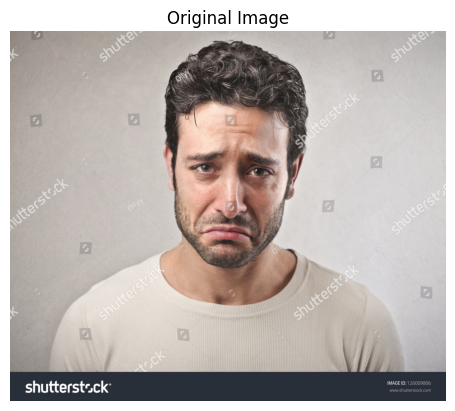

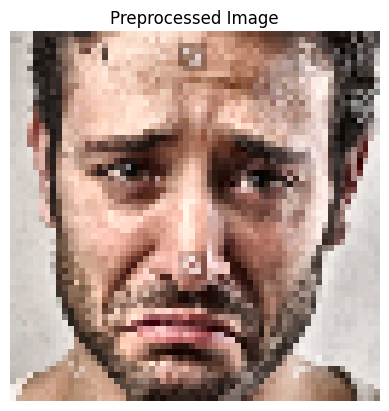

In [91]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis(False)
plt.title("Original Image")
plt.show();

plt.imshow(preprocessed_image.detach().numpy())
plt.axis(False)
plt.title("Preprocessed Image")
plt.show();

In [111]:
# Prediction
with torch.inference_mode():
    pred_logits = TinyVGG_model(preprocessed_image.permute(2,0,1).unsqueeze(dim=0).to(torch.float32).to(device))

    # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1).argmax(dim=1)
    print(itol_FER[pred_probs.item()])

sad


In [123]:
# Prediction fuction
def predict_FER(image):
  image = preprocessing_pipeline(image)
  with torch.inference_mode():
    pred_logits = TinyVGG_model(image.permute(2,0,1).unsqueeze(dim=0).to(torch.float32).to(device))

    # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1)
    label = itol_FER[pred_probs.argmax(dim=1).item()]
  return label, pred_probs

In [124]:
result = predict_FER(test_image)
print(result)

('sad', tensor([[7.6950e-02, 9.2303e-01, 2.0625e-13, 1.1884e-05, 2.2963e-13, 9.2401e-06,
         1.3201e-07]], device='cuda:0'))


# 3. Decision Fusion

In [177]:
def decision_fusion_prediction(text, image, text_weight=1, image_weight=1):

  text_label, text_probs = predict_text_expression(text)
  image_label, image_probs = predict_FER(image)

  # Perform weighted sum of probabilities
  fused_probs = (text_probs * text_weight + image_probs * image_weight) / (text_weight + image_weight)

  fused_label = fused_probs.argmax(dim=-1)

  return itol_FER[fused_label.item()], fused_probs, text_label, text_probs, image_label, image_probs

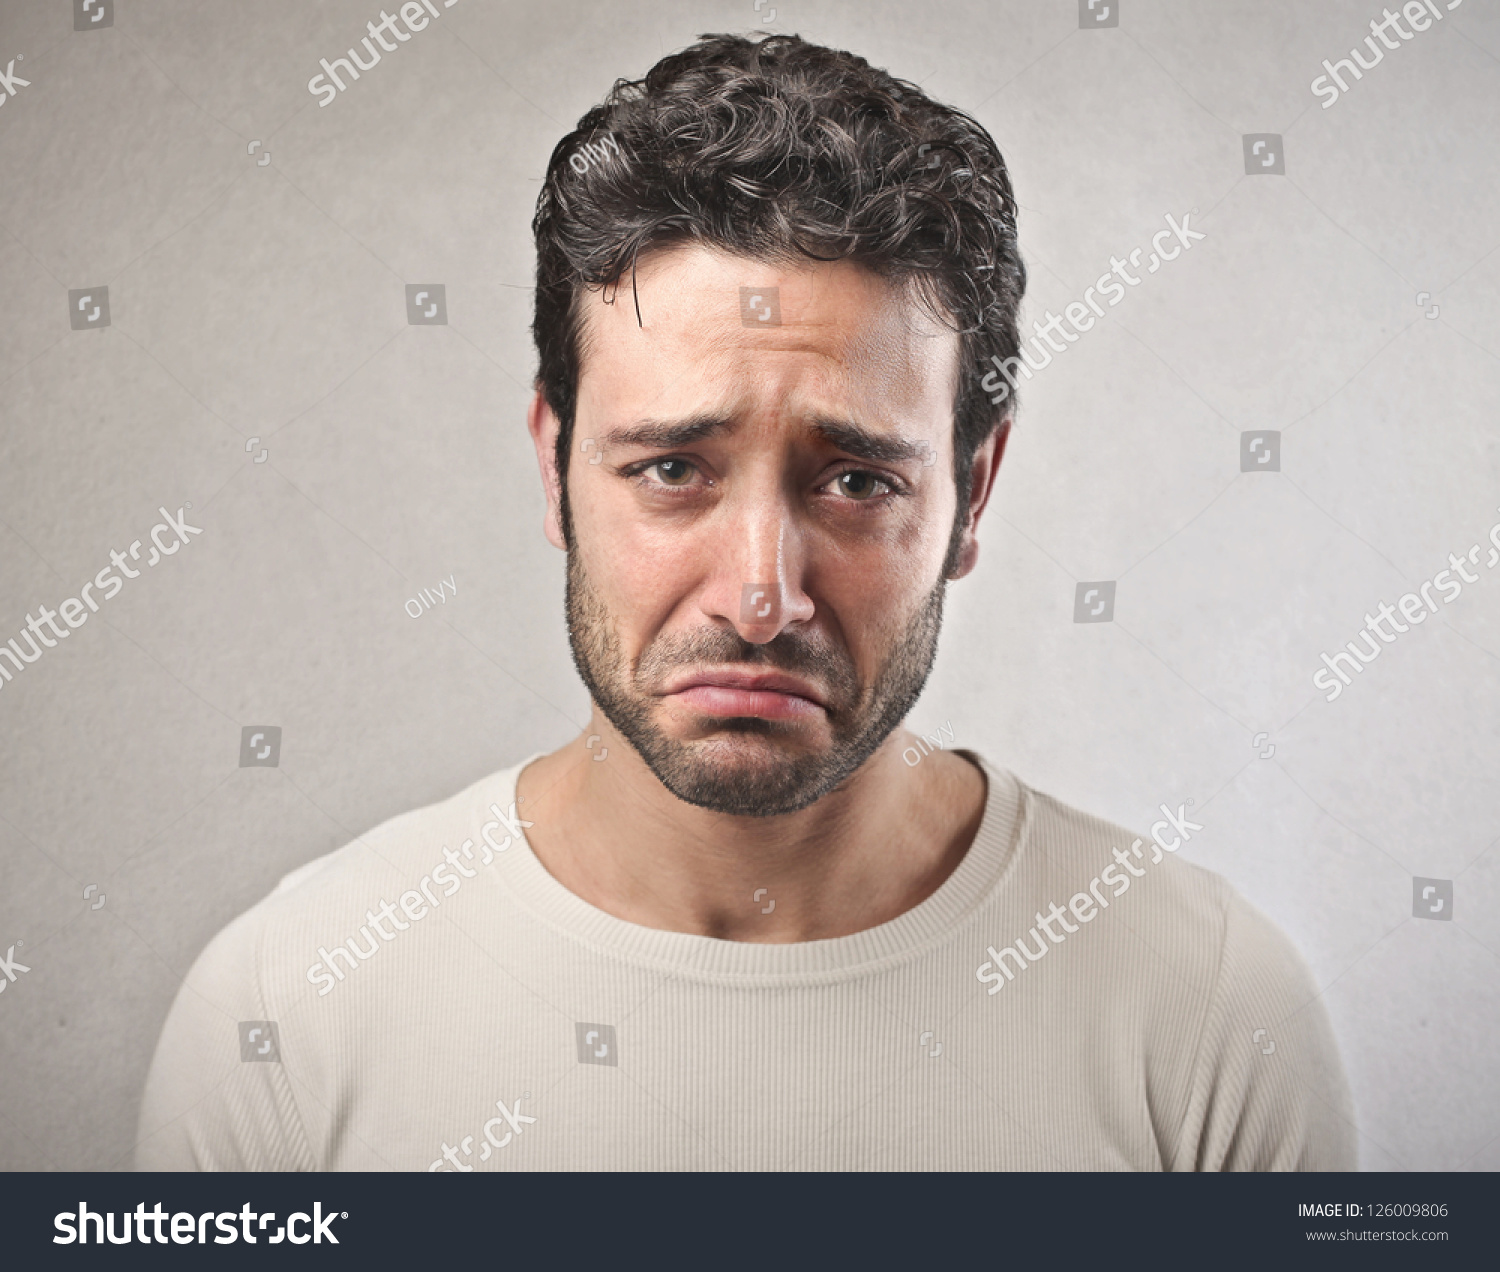

In [178]:
sample_text = "Lost in thought, feeling empty, missing the warmth of happiness."
sample_image = test_image
test_image

In [179]:
decision_fusion_prediction(sample_text, sample_image)

('sad',
 tensor([[1.6776e-02, 9.8001e-01, 2.1031e-07, 5.4561e-04, 1.4675e-06, 6.1061e-05,
          2.6075e-03]], device='cuda:0'),
 'sad',
 tensor([2.4125e-07, 9.9987e-01, 4.2063e-07, 1.0364e-06, 2.9349e-06, 1.2075e-04,
         1.8899e-07], device='cuda:0'),
 'sad',
 tensor([[3.3552e-02, 9.6014e-01, 5.4944e-13, 1.0902e-03, 2.3454e-12, 1.3697e-06,
          5.2148e-03]], device='cuda:0'))